In [1]:
%run functions.py

import numpy as np
import pandas as pd
from scipy.io import loadmat
import pickle

from sklearn.svm import LinearSVC
from sklearn.linear_model import Lasso,ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from warnings import filterwarnings

# Task 2 - Regression 

## Load settings

In [2]:
grid = None
k=10 # Define k for crossvalidation
seed = 42 # Seed to use
feature_tot = 0 # Total selected features -> Start at 0 before PCA
taskname = "task2"
db_set = "datasets/ChemTrainNew.mat"
filedir = "/home/fredrik/Documents/Learning_systems/Labs/Project/"
#filedir = "C:/Users/fredr/Documents/github-projects/Learning_systems/Labs/Project/"

scoring='neg_mean_squared_error' # Scoring method for GridsearchCV
score_function = f_regression # Score function for Feature selection


np.random.seed(seed) # Define the random seed

In [3]:
# GridSearchCV
estimators = [
    ('clf', 'passthrough'),
]
param_grid = [
    {
        'clf':[SVR()],
        'clf__C':[0.1,10,100],
        'clf__gamma':['scale', 'auto',2]
    },{
        'clf':[Lasso(random_state=seed)],
        'clf__alpha':[0.1,1.0,2.0,5.0],
        'clf__max_iter':[100,1000,5000],

    },{
        'clf':[ElasticNet(random_state=seed)],
        'clf__alpha':[0.1,1.0,2.0,5.0],
        'clf__max_iter':[100,1000,5000],
    },{
        'clf':[RandomForestRegressor(random_state=seed)],  
        'clf__n_estimators':[100,150,200],
        
    },{
        'clf':[MLPRegressor()],
        'clf__hidden_layer_sizes':[(100,20)],
        'clf__activation':['relu'],
        'clf__solver':['adam', 'lbfgs'],
        'clf__alpha':[0.0001,0.001,0.1],
        'clf__max_iter':[200,400],
        'clf__early_stopping':[True, False]
    }
]

## Load dataset

In [4]:
mat = loadmat(db_set)
input_train = mat['XtrainDS']

target_train = mat['YtrainDS'].reshape(len(input_train))
input_test = mat['XtestDS']


input_train = input_train[:,1:]
input_test = input_test[:,1:]

## Data info

In [5]:
get_data_info(input_train, target_train)

Length of 4466
X.shape: (4466, 64) y.shape: (4466,)
Contains Nan: False False
Contains +inf: False False
Contains -inf: False False


## Preprocess
Normalize the dataset

In [6]:
input_train, input_test, target_train, input_train_copy, input_train_copy_normalized = preprocessing(input_train,target_train, input_test)

Length of input: 4466


## Feature distribution

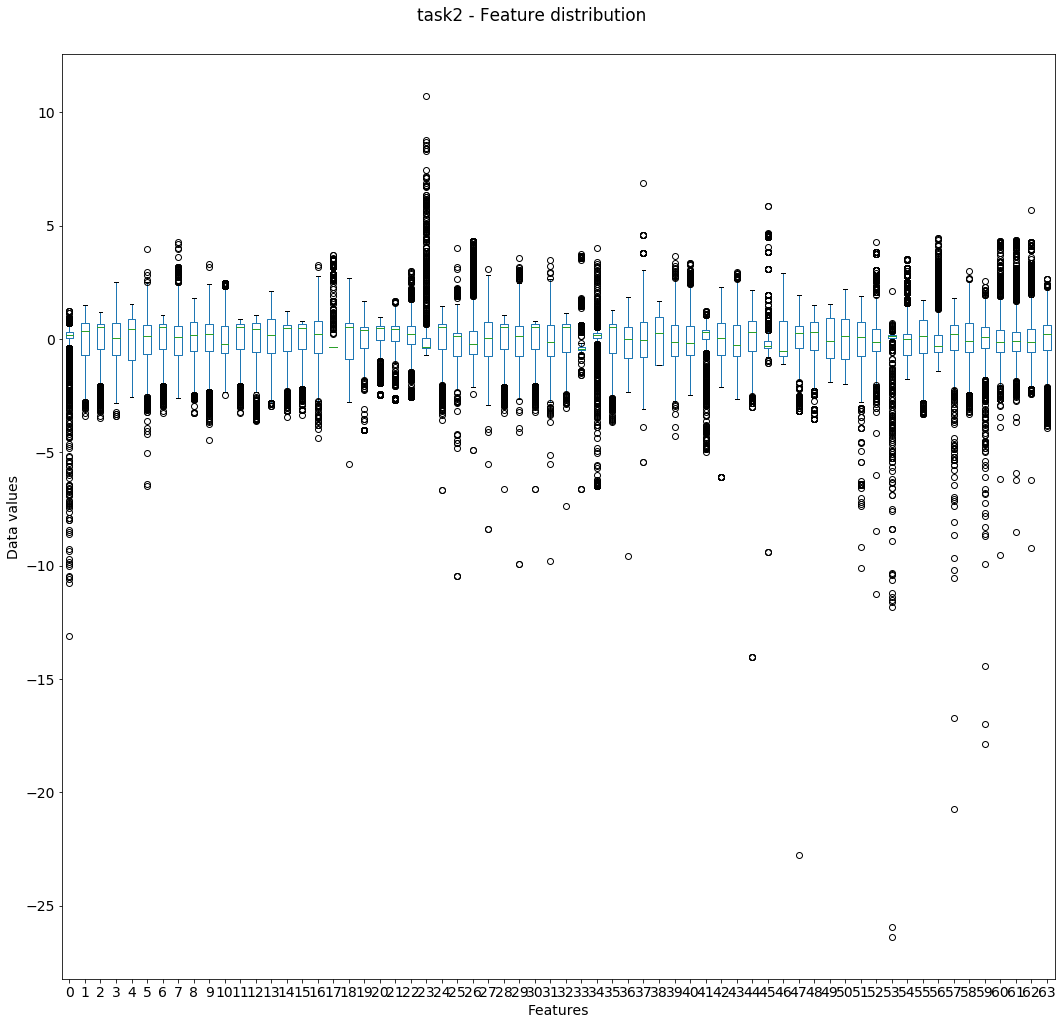

In [7]:
plot_feature_distribution(input_train, filedir=filedir, taskname=taskname)

## Feature reduction
Reduce dimensionality by PCA transform

In [8]:
feature_tot, pca, pca_input = feature_reduction(input_train, target_train,input_train_copy)

original shape:    (4466, 64)
transformed shape: (4466, 27)
Explained variance: [0.35441177 0.10266607 0.08168297 0.06419575 0.04078661 0.03237526
 0.02810572 0.02543366 0.02006375 0.01845131 0.01694614 0.01636917
 0.01491138 0.01382942 0.01316199 0.01296958 0.01199725 0.01115177
 0.01076023 0.00977379 0.00960008 0.00898462 0.00881979 0.00757174
 0.00678392 0.0063734  0.00541192]


## Feature extraction

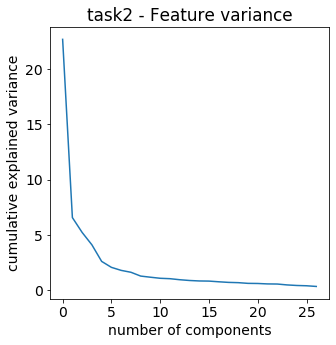

In [9]:
plot_feature_variance(pca_input, filedir=filedir, taskname=taskname)

## Feature selection
Extract top features above depending on PCA

[ 1  2  6  7  8 11 12 14 15 16 18 19 24 25 27 28 30 32 34 35 36 43 44 47
 54 56 63]
Shape of input: (4466, 64)


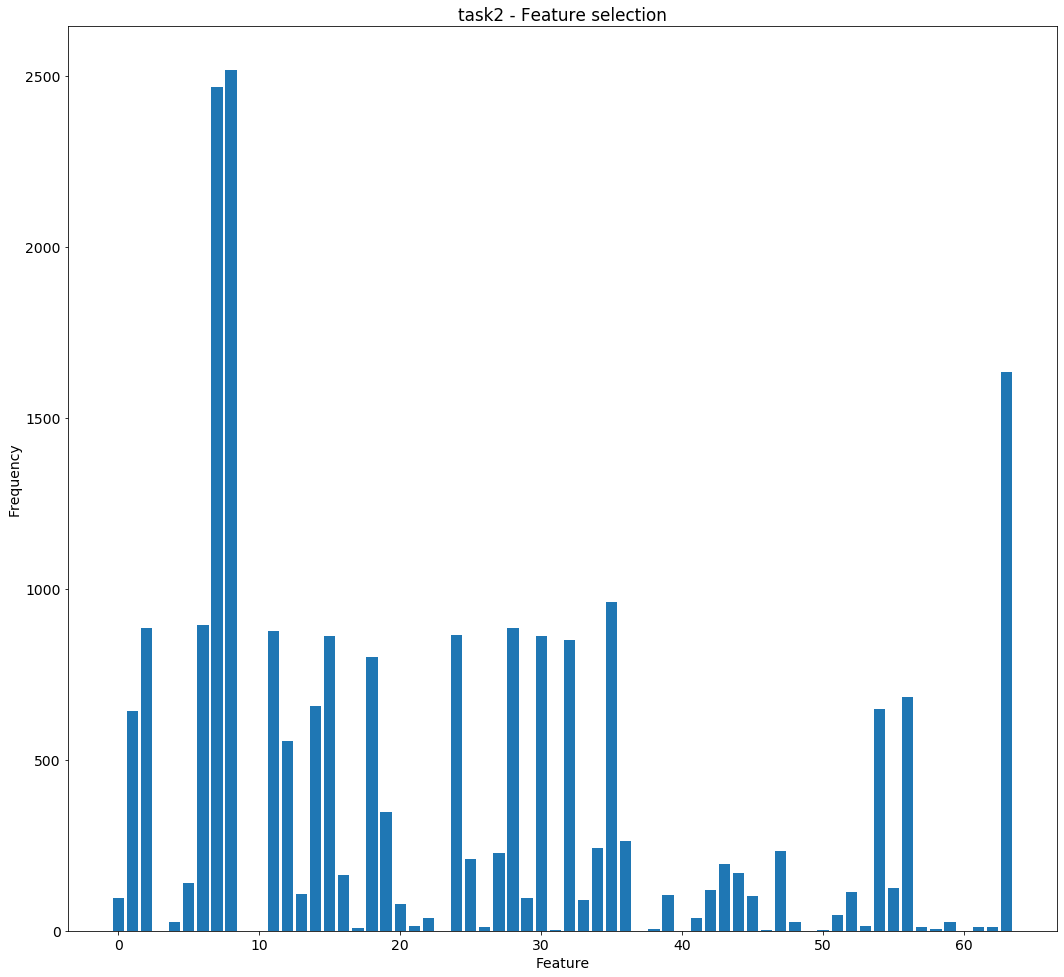

In [10]:
input_train_fs, input_test_fs = feature_selection(score_function, input_train, target_train, input_test, filedir=filedir, taskname=taskname,feature_tot=feature_tot)

## Feature Relationship

x-axis contain features and y is frequency of values


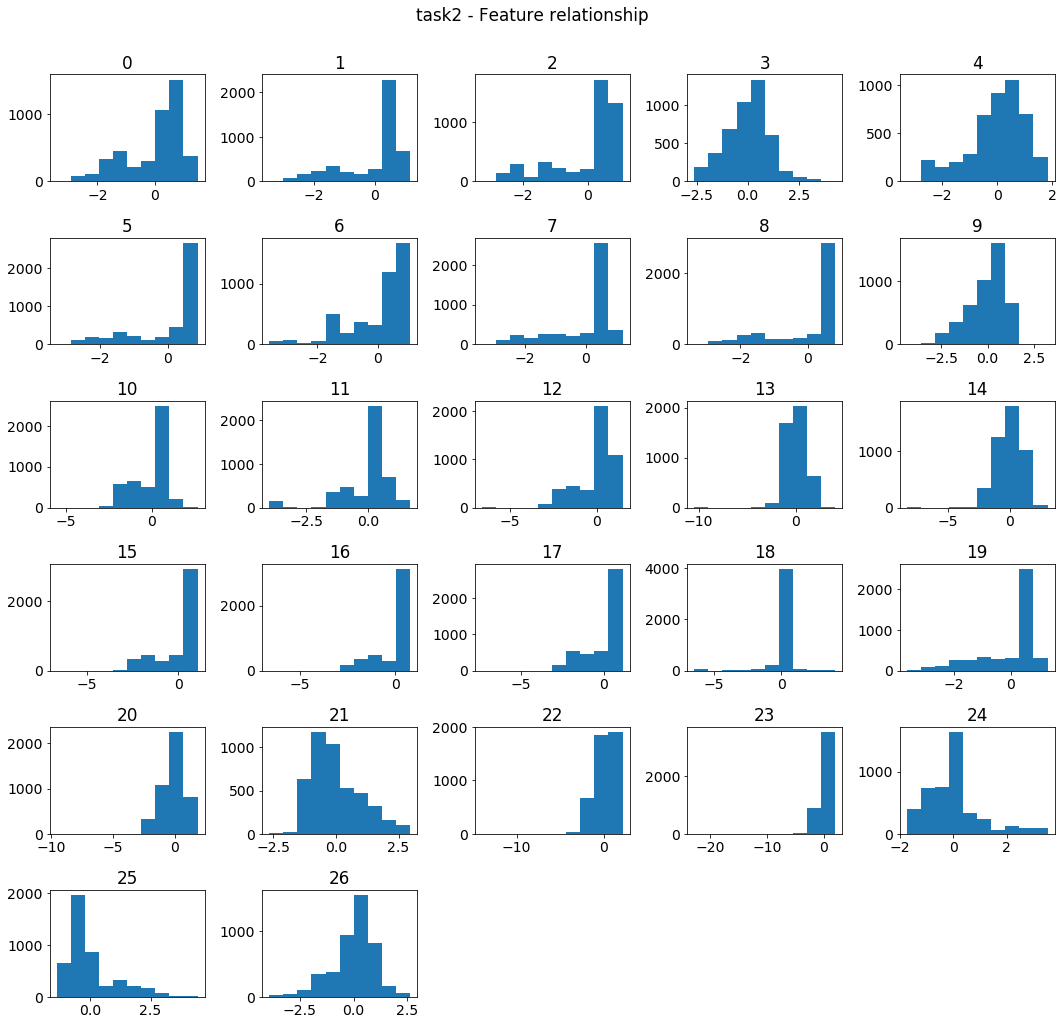

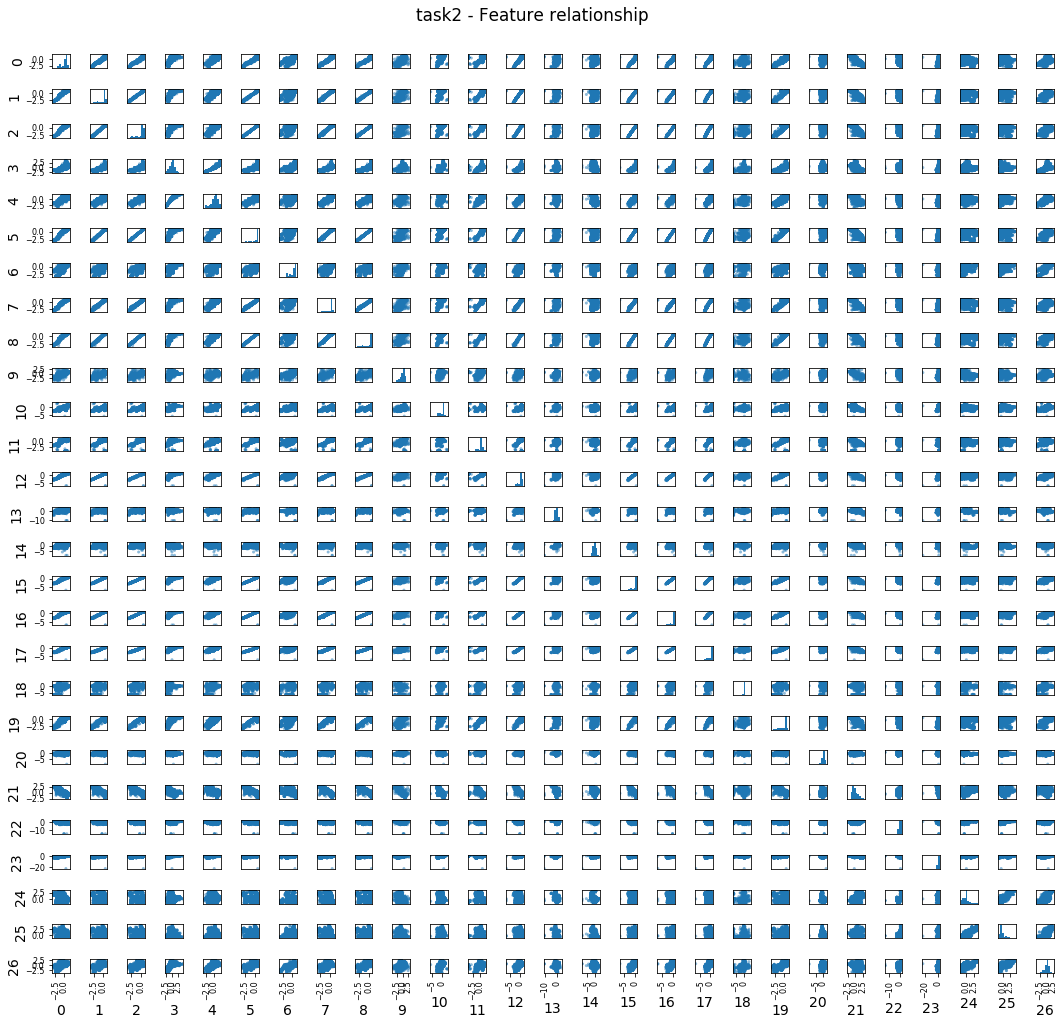

In [11]:
plot_feature_relationship(input_train_fs, filedir, taskname)

## Hyperparameter tuning

In [12]:
# GridSearchCV
grid = parameter_tuning(estimators, param_grid, input_train_fs, target_train, scoring=scoring, k=k)


Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 420 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 40.4min finished


## Save model

In [13]:
save_model(grid, filedir=filedir, taskname=taskname)

Save model into: /home/fredrik/Documents/Learning_systems/Labs/Project/Models/task2.joblib


## Load model

In [12]:
if not grid: 
    grid = load_model(filedir=filedir, taskname=taskname)

Loading model:  /home/fredrik/Documents/Learning_systems/Labs/Project/Models/task2.joblib


## Get Model info

In [13]:
get_model_info(grid)

    mean_test_score  std_test_score  rank_test_score  \
4        -78.327504       68.287491                1   
3        -79.100927       70.341284                2   
12       -91.176367       91.906112                3   
14       -91.176367       91.906112                3   
13       -91.176367       91.906112                3   

                                                                                                                                                                                                                                                   params  
4                                                         {'clf': SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False), 'clf__C': 10, 'clf__gamma': 'auto'}  
3                                                        {'clf': SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', ma

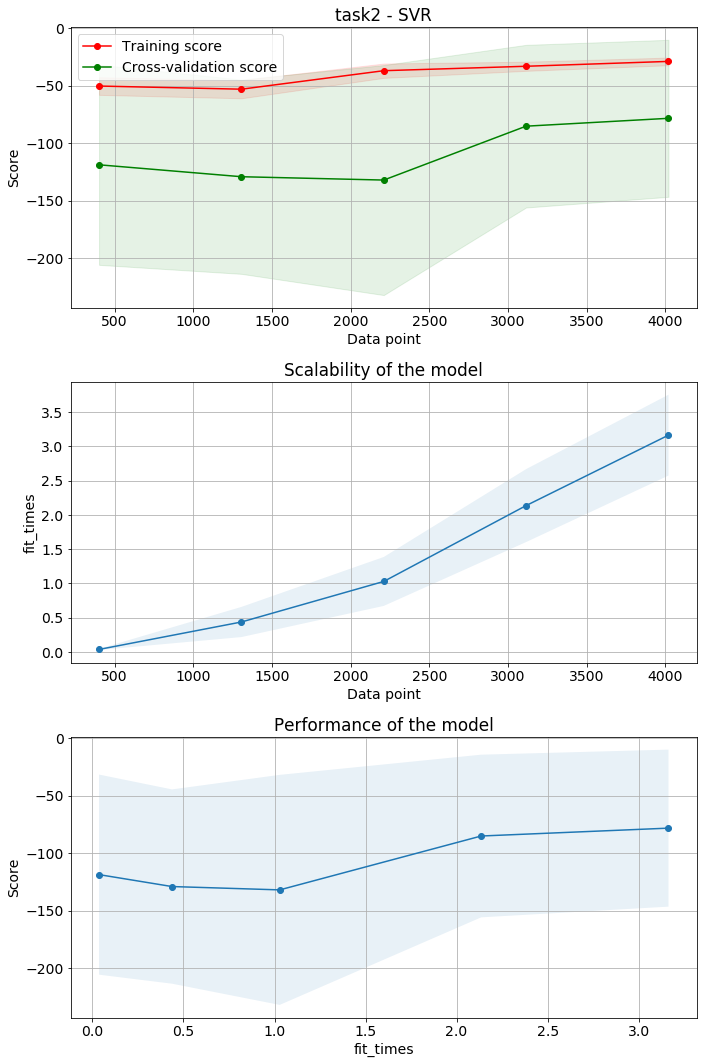

In [14]:
validate_curve(grid, input_train_fs, target_train, filedir=filedir, taskname=taskname,scoring=scoring, k=k)

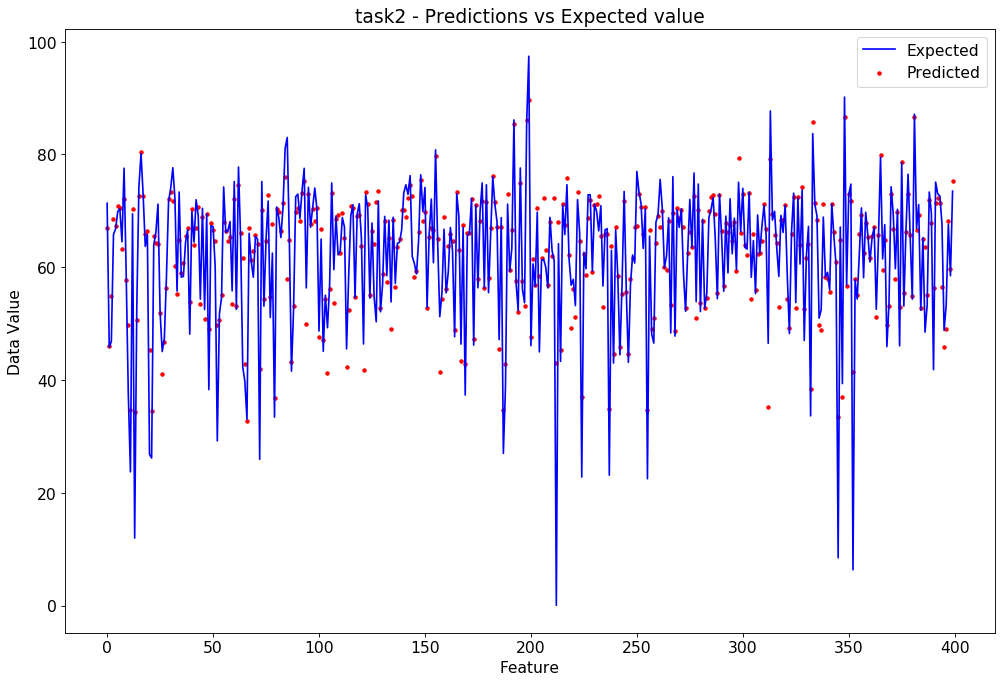

In [15]:
display_model_predict(grid, input_train_fs, target_train, filedir=filedir, taskname=taskname,datapoints=400)

# Predict testset

In [16]:
_,predict = predict_model(grid, input_train_fs, target_train, input_test_fs)
save_prediction(predict, filedir, taskname)
print(predict)

[65.01962408 65.01891436 63.88760561 65.36895422 65.28013764 65.60628828
 65.60342716 65.43735365 66.16112858 66.6841006  66.16714075 66.10417927
 66.62301513 65.97125648 65.18950725 66.33957563 66.59353928 66.19012057
 65.9580327  65.54790886 65.61704625 66.1382438  65.99070772 65.39234555
 65.68996945 65.72577874 65.73165752 65.79112987 65.18296684 65.45733167
 65.18827479 64.98413655 65.19543455 65.91726579 65.52826439 64.99935375
 66.03979604 65.2352121  65.80465222 66.16789138 65.48305754 66.42224416
 65.2498419  65.80644715 65.39668881 65.69147699 65.6315248  65.23536752
 65.86515373 66.46128083 66.67596639 65.35255224 66.35563552 65.61498593
 65.98546727 66.15036957 66.13557655 65.88565726 65.73668421 65.85541625
 65.96301904 66.03511856 65.9798815  66.49996263 65.78363871 65.64452286
 65.67552883 67.16693104 66.37649748 66.19171268 66.78843921 66.01493657
 65.94332669 65.94687469 66.46815111 67.27780357 67.16910618 66.83045446
 67.25297412 67.20499308 67.04784492 66.49916016 66